In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import sys
waketracking_path = '/Users/equon/waketracking'
if not waketracking_path in sys.path:
    sys.path.append(waketracking_path)

In [4]:
from samwich.dataloaders import SpinnerLidarMatlab

# Example: processing lidar data
written by Eliot Quon [eliot.quon@nrel.gov]

In [5]:
#
# INPUTS HERE
#
fpath = 'lidar.z01.b0.20170123.225000.mat'
coordsys = 'streamwiseCS'
focusdist = 5.0 # diameters downstream to extract
ds = 2.5 # grid spacing for output grid

## load the lidar data

In [6]:
lidar = SpinnerLidarMatlab(fpath)

Loaded lidar.z01.b0.20170123.225000.mat (b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Tue Apr  2 17:30:50 2019')
  x/D available: [1 2 3 4 5]
  coordinate systems available: ['lidarCS', 'nacelleCS', 'streamwiseCS', 'swiftCS']
  converted 271 times from units "seconds from 1970-01-00 00:00:00 UTC"


In [7]:
lidar

Datafile: lidar.z01.b0.20170123.225000.mat
x/D: [1 2 3 4 5]
t: 271 [2017-01-23 22:50:03 ... 2017-01-23 22:59:58 ]

In [8]:
assert (focusdist in lidar.scan_avg.focus_dist_set_D)

## interpolate to regular grid, for comparison to numerical models
Note: this part requires `scipy`

In [9]:
%time lidar.interpolate(focaldist_D=focusdist, ds=ds)
# CPU times: user 1.46 s, sys: 67.1 ms, total: 1.52 s
# Wall time: 1.52 s

Indices filtered from 271 to 231 times
  x range (detected): 102.60862326763122 139.78096395758593
  y range (input): -77.5 95.0
  z range (input): 0.0 105.0
  new x range (forcing 2D): 133.75 135.18449987465368
  interpolation grid: [[133.75, 136.25, 2.5], [-77.5, 95.0, 2.5], [0.0, 105.0, 2.5]]
Using scipy.interpolate.griddata with method=linear


Processed vlos [m/s] at 2017-01-23 22:59:42.014565 (223/231)

CPU times: user 1.46 s, sys: 67.1 ms, total: 1.52 s
Wall time: 1.52 s


Processed vlos [m/s] at 2017-01-23 22:59:58.142761 (231/231)


In [10]:
# shape of x,y,z : (NY,NZ)
# shape of u : (Ntimes,NY,NZ)
x,y,z,u = lidar.sliceI()

Slicing data at i=0 x=135.0


In [11]:
# create plotting grid
# - resulting shape of yy,zz : (NY+1, NZ+1)
y0 = np.linspace(y[0,0]-ds/2, y[-1,0]+ds/2, lidar.NY+1)
z0 = np.linspace(z[0,0]-ds/2, z[0,-1]+ds/2, lidar.NZ+1)
yy,zz = np.meshgrid(y0, z0, indexing='ij')

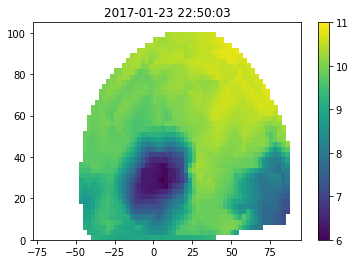

In [12]:
# Plot in FFOR
itime = 0
cmsh = plt.pcolormesh(yy, zz, u[itime,:,:], vmin=6,vmax=11)
ttl = plt.title(lidar.t[itime].strftime('%Y-%m-%d %H:%M:%S'))
cbar = plt.colorbar(cmsh)

## raw data
(if you're curious)

In [13]:
# line-of-sight velocity
vlos = lidar.scan.vlos

In [14]:
# projection into specified coordinate system
projection = getattr(lidar.scan,coordsys).vlos_projection

In [15]:
at_selected_D = (lidar.scan_avg.focus_dist_set_D == focusdist)
print(np.count_nonzero(at_selected_D), 'scans out of',lidar.Ntimes,'selected')

231 scans out of 231 selected


In [16]:
# now calculate velocities
uscan = vlos / projection
uscan = uscan[at_selected_D]

In [17]:
# get sample locations
yscan = getattr(lidar.scan,coordsys).y[at_selected_D]
zscan = getattr(lidar.scan,coordsys).z[at_selected_D]

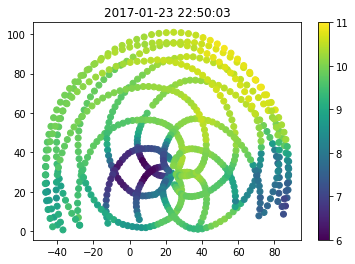

In [18]:
# sample plot
itime = 0
scat = plt.scatter(yscan[itime], zscan[itime], c=uscan[itime],
                   vmin=6,vmax=11)
ttl = plt.title(lidar.t[itime].strftime('%Y-%m-%d %H:%M:%S'))
cbar = plt.colorbar(scat)